### Pyramid Blending

In [179]:
import cv2
import numpy as np
from commonfunctions import *
import skimage
from skimage.color import rgb2gray

### references
Blending  - https://www.cs.toronto.edu/~mangas/teaching/320/assignments/a3/spline83.pdf

## Gaussian pyramid
smooth then down-sample by a factor of 1/2.
*smoothing supress high frequencies therefore lower the bar for nyquist criteria and avoid aliasing as possible.*

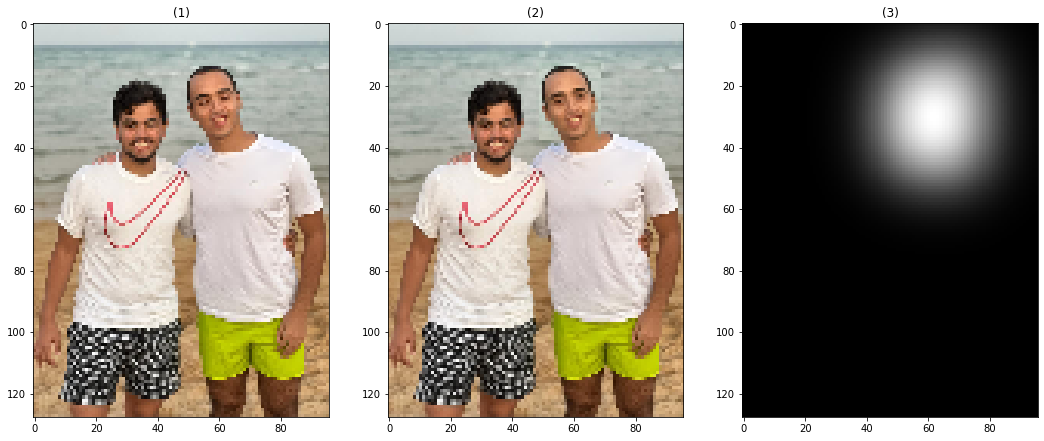

In [180]:
image1 = io.imread('./images/y.jpg')
image2 = io.imread('./images/reference_w_mfatah.jpg')
# mask used to mark required part of image 2 to be blended
mask = io.imread('./images/img1_mask.jpg')
# resize factor is used to make image smaller for fast preprocessing
resize_factor = 8
image1 = cv2.resize(image1, dsize=(image1.shape[1]//resize_factor, image1.shape[0]//resize_factor))
image2 = cv2.resize(image2, dsize=(image2.shape[1]//resize_factor, image2.shape[0]//resize_factor))
if image1.shape[0] > image2.shape[0]:
    image1 = cv2.resize(image1, dsize=(image2.shape[1], image2.shape[0]))
else:
    image2 = cv2.resize(image2, dsize=(image1.shape[1], image1.shape[0]))
mask = cv2.resize(mask, dsize=(image1.shape[1], image1.shape[0]))
mask = skimage.filters.gaussian(mask,sigma=10)
show_images([image1, image2,mask])

In [181]:
def gaussian_pyramid(image, sigma=0.5):
    """
    construct the gaussian pyramid by down-sampling and applying gaussian filter at each stage
    :param image: input image to construct pyramid for
    :return pyramid: list on images constructing the pyramid
    """
    # the pyramid base start with the image
    _image = np.copy(image)
    pyramid = [_image]
    x, y = _image.shape[0], _image.shape[1]
    while x > 2 and y > 2:
        # apply gaussian filter then down-sample with a factor of 2
        current_img = np.copy(pyramid[-1])
        current_img = skimage.filters.gaussian(current_img, sigma=sigma)
        x, y = current_img.shape[1]//2, current_img.shape[0]//2
        current_img = cv2.resize(current_img, dsize=(x, y))
        pyramid.append(current_img)
    return pyramid

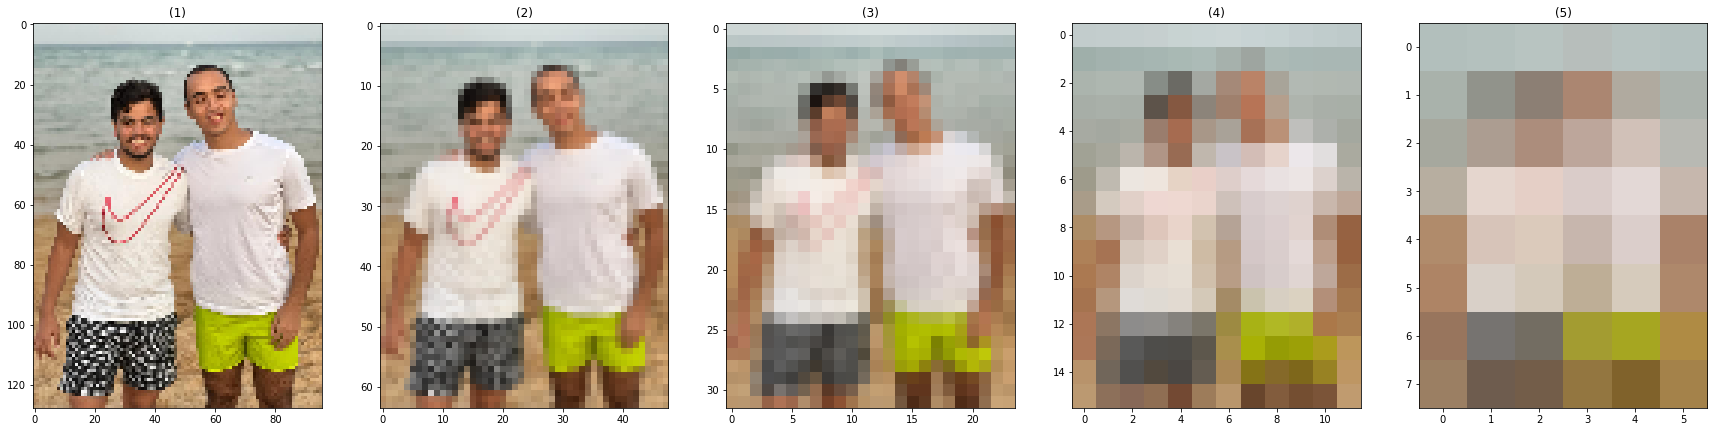

In [182]:
p = gaussian_pyramid(image1)
show_images([p[0],p[1],p[2],p[3],p[4]])

In [183]:
def laplacian_pyramid(image, sigma=0.5):
    """
    construct the laplacian pyramid by up-sampling and applying gaussian filter in image k
    then subtract it from image k-1 in the gaussian pyramid
    by this way you get the lost information due to down sampling
    :param image: input image to construct pyramid for
    :return pyramid: list on images constructing the pyramid
    """
    # first of all get the gaussian pyramid
    gaus_pyramid = gaussian_pyramid(image, sigma)
    lap_pyramid = []
    for i in range(len(gaus_pyramid)):
        # up-sample with a factor of 2 then apply gaussian filter
        # Since there is no image gN + 1 to serve as the prediction image for gN, we say LN = gN.
        if i == len(gaus_pyramid) - 1:
            lap_pyramid.append(gaus_pyramid[i])
            break
        gi = np.copy(gaus_pyramid[i])
        gi_next = np.copy(gaus_pyramid[i+1])
        # up-sampling to gi
        prediction = cv2.resize(gi_next, dsize=(gi.shape[1], gi.shape[0]))
        # apply gaussian filter
        prediction = skimage.filters.gaussian(prediction, sigma=sigma)
        lap_pyramid.append(gi - prediction)
    return lap_pyramid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


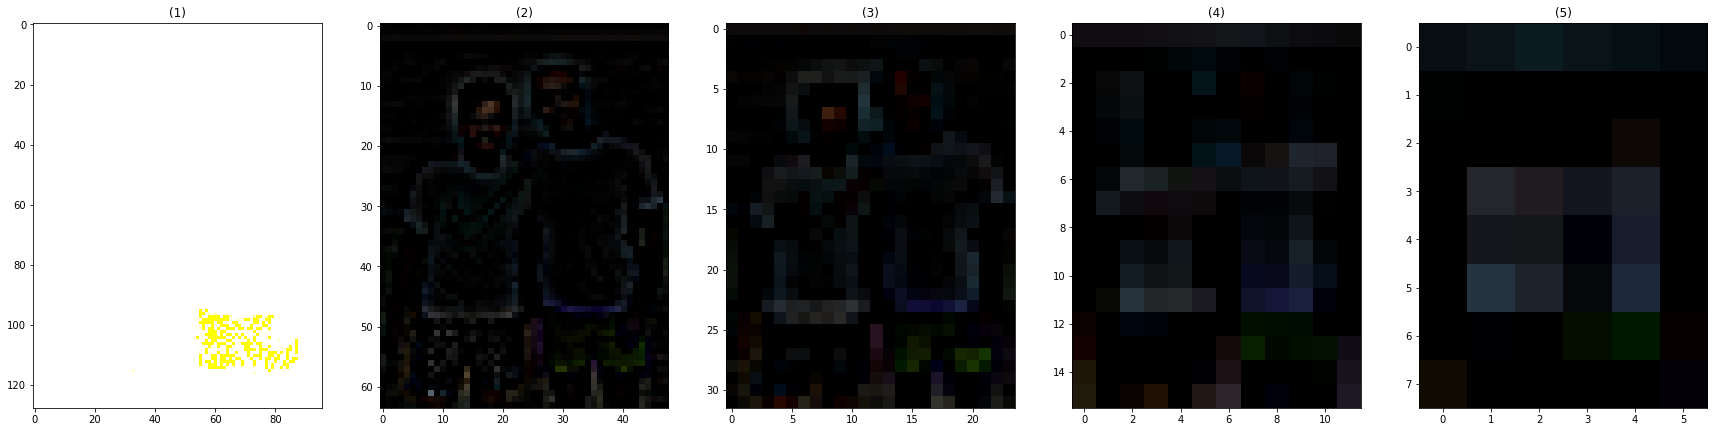

In [184]:
p = laplacian_pyramid(image1)
show_images([p[0],p[1],p[2],p[3],p[4]])

In [185]:
def blending(A, B, mask, sigma = 0.5):
    """
    blend pyramids of image A, B with the given mask
    A, B and mask must all have same size
    :param A: first image
    :param B: second image
    :param mask: the required mask to blend the region of interest
    :return blended_pyramid: list of blended pyramid
    """
    if mask.shape != A.shape or mask.shape != B.shape:
        raise Exception("input images and mask all must have same size.")
    # get gaussian_pyramid of mask
    g_mask = gaussian_pyramid(mask, sigma)
    # get laplacian_pyramid of A and B
    l_A = laplacian_pyramid(A, sigma)
    l_B = laplacian_pyramid(B, sigma)
    # then blend smoothly using mask pyramid
    blended_pyramid = []
    for i in range(len(l_A)):
        combined_lap = g_mask[i]*l_A[i] + (1 - g_mask[i])*l_B[i]
        blended_pyramid.append(combined_lap)
    return blended_pyramid

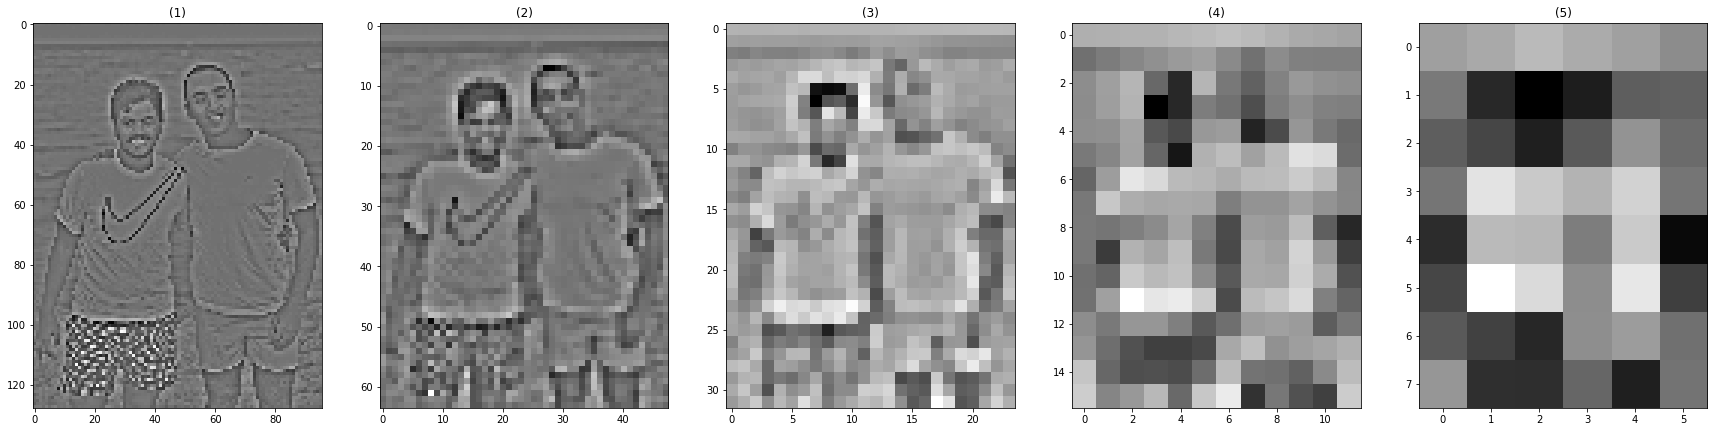

In [186]:
p = blending(rgb2gray(image1),rgb2gray(image2), mask)
show_images([p[0],p[1],p[2],p[3],p[4]])

In [187]:
def reconstruct(blended_pyramid, sigma=0.5):
    """
    reconstruct the blended image from the ground up
    :param blended_pyramid:
    :return: blended_image
    """
    # reverse blended pyramid
    stair = blended_pyramid[::-1]
    blended_image = stair[0]
    for i in range(1, len(stair)):
        up_sample = cv2.resize(blended_image, dsize=(stair[i].shape[1], stair[i].shape[0]))
        blended_image = skimage.filters.gaussian(up_sample, sigma=sigma) + stair[i]
    return blended_image

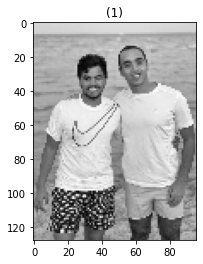

In [188]:
img = reconstruct(blending(rgb2gray(image2),rgb2gray(image1), mask))
show_images([img])

In [189]:
def color_blending(img1, img2, mask, sigma = 0.5):
    """
    takes 2 images and a mask then blends the white area from the mask into img2.
    img1, img2 and the mask all must have same size
    :param img1: the image that have the nice face
    :param img2: reference frame background that has bad face to be replaced
    :param mask: the mask has all black other than a white area aligned with the face in img1
    :param sigma: controls sigma used in gaussian filter
    :return: colored blended image
    """
    if np.max(img1) > 1:
        img1 = img1 / 255
    if np.max(img2) > 1:
        img2 = img2 / 255

    img1R, img1B, img1G = cv2.split(img1)
    img2R, img2B, img2G = cv2.split(img2)

    blendR = reconstruct(blending(img1R, img2R, mask,sigma), sigma)
    blendB = reconstruct(blending(img1B, img2B, mask,sigma), sigma)
    blendG = reconstruct(blending(img1G, img2G, mask,sigma), sigma)

    blended_image = cv2.merge((blendR, blendB, blendG))
    return blended_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


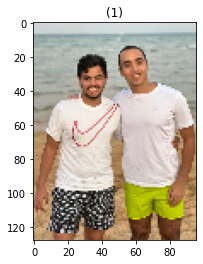

In [190]:
output = color_blending(image2, image1, mask,sigma=20)
show_images([output])